In [1]:
import argparse
import pathlib
import random
from collections import deque
from typing import List, Dict, Tuple, Union
from data import Dataset, SuperclassDataset
from data_utils import *
from sampling import *
from models import BetaBernoulli
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from utils import mean_reciprocal_rank
%matplotlib inline  

import matplotlib;matplotlib.rcParams['font.size'] = 10
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
LINEWIDTH = 13.97

LOG_FREQ = 10
RUNS = 100
method_list = ['random_arm', 'random_data', 'random_arm_informed', 'random_data_informed', 'ts_uniform', 'ts_informed']
method_format = {'random_arm': ('Random Arm', 'b', '.', '-'), 
                 'random_data': ('Random Datapoint', 'g', '^', '-'), 
                 'random_arm_informed': ('Random Arm Informed', 'b', '.', '--'), 
                 'random_data_informed': ('Random Datapoint Informed', 'g', '^', '--'), 
                 'ts_uniform': ('TS Symmetric', 'k', '*', '-'), 
                 'ts_informed': ('TS Informed', 'r', '+', '-'),
                }
DATASET_LIST = ['cifar100', 'svhn', '20newsgroup', 'dbpedia'] #'imagenet', 
output_dir = pathlib.Path("../output/confusion_matrix")

In [2]:
metric = 'confusion_matrix' # 'ece', 'confusion_matrix'
group_method = 'predicted_class'
pseudocount = 1
RUNS = 100
superclass = False #todo: superclass=true
cost_matrix = None
topk = 1

In [3]:
# load results and compute ground truth
ground_truth = {}
weight_k = {}
l2_error = {}
logp = {} # log likelihood of each estimated confusion matrix under dirichlet distribution

for dataset_name in DATASET_LIST: # takes 4 minutes to load results of imagenet
    ground_truth[dataset_name] = {}
    l2_error[dataset_name] = {}
    logp[dataset_name] = {}
    
    # load data
    if len(dataset_name) > len('superclass') and dataset_name[-len('superclass'):] == 'superclass':
        superclass = True
    else:
        superclass = False
    
    print(dataset_name, superclass)
    experiment_name = '%s_top%d_pseudocount%d' % (dataset_name, topk, pseudocount)
    if superclass:
        dataset = SuperclassDataset.load_from_text(dataset_name.split('_')[0], CIFAR100_SUPERCLASS_LOOKUP)
        # no need to group (grouped by superclass automatically)
    else:
        dataset = Dataset.load_from_text(dataset_name)
        dataset.group(group_method = group_method)
    # ground truth
    weight_k[dataset_name] = dataset.weight_k
    confusion_probs = dataset.confusion_probs
    confusion_probs = confusion_probs + np.ones(confusion_probs.shape) * 1e-6
    confusion_probs = confusion_probs / confusion_probs.sum(axis=1)
    ground_truth[dataset_name]['confusion_matrix'] = confusion_probs
    ground_truth[dataset_name]['confusion_matrix'] = \
        np.load(open(output_dir / experiment_name / ('mpe_log_%s_run%d.npy' % ('ts_informed', 0)), 'rb'))[-1]
     # initalize l2 error
    for method_name in method_list:
        l2_error[dataset_name][method_name] = np.zeros((RUNS, dataset.__len__() // LOG_FREQ))
        logp[dataset_name][method_name] = np.zeros((RUNS, dataset.__len__() // LOG_FREQ))
        # load results
        for r in range(RUNS):
            mpe_log = np.load(open(output_dir / experiment_name / ('mpe_log_%s_run%d.npy' % (method_name, r)), 'rb'))            
            l2_eval = mpe_log - ground_truth[dataset_name]['confusion_matrix']
            l2_eval = l2_eval ** 2
            l2_eval = np.sum(l2_eval,axis=2)
            l2_error[dataset_name][method_name][r] = np.array([(l2_eval[i] * weight_k[dataset_name]).sum()
                                                               for i in range(dataset.__len__() // LOG_FREQ)])
    # baseline
    print('sss')
    mpe_diag = np.identity(dataset.num_groups)
    l2_eval = mpe_diag - ground_truth[dataset_name]['confusion_matrix']
    l2_eval = l2_eval ** 2
    l2_eval = np.sum(l2_eval,axis=1)
    l2_error[dataset_name]['diagonal'] = np.array((l2_eval * weight_k[dataset_name]).sum())

    mpe_ones = np.ones((dataset.num_groups,dataset.num_groups))
    mpe_ones /= dataset.num_groups
    l2_eval = mpe_ones - ground_truth[dataset_name]['confusion_matrix']
    l2_eval = l2_eval ** 2
    l2_eval = np.sum(l2_eval,axis=1)
    l2_error[dataset_name]['ones'] = np.array((l2_eval * weight_k[dataset_name]).sum())

    mpe_scores = confusion_probs
    l2_eval = mpe_scores - ground_truth[dataset_name]['confusion_matrix']
    l2_eval = l2_eval ** 2
    l2_eval = np.sum(l2_eval,axis=1)
    l2_error[dataset_name]['scores'] = np.array((l2_eval * weight_k[dataset_name]).sum())
    

cifar100 False
sss
svhn False
sss
20newsgroup False
sss
dbpedia False
sss


# $L_2$

Text(0, 0.5, '$L_2$ Error')

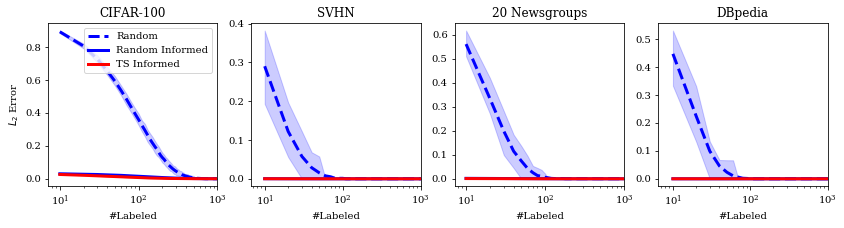

In [4]:
# plot
method_format = {#'random_arm': ('Random Arm', 'g', '.', '--'), 
                 'random_data': ('Random', 'b', '^', '--'), 
                 #'random_arm_informed': ('Random Arm Informed', 'g', '.', '-'), 
                 'random_data_informed': ('Random Informed', 'b', '^', '-'), 
                 #'ts_uniform': ('TS Symmetric', 'k', '*', '-'), 
                 'ts_informed': ('TS Informed', 'r', '+', '-'),}


fig, axes = plt.subplots(nrows=1, ncols=len(DATASET_LIST), figsize=(LINEWIDTH,3),
                        gridspec_kw = {'wspace':0.2, 'hspace':0.25})
for i, dataset_name in enumerate(DATASET_LIST):
    start = 0
    num_steps = l2_error[dataset_name][method_name].shape[1] - 1
    stepsize = 1
    for method_name in method_format:
        legend_name, color, marker, linestyle = method_format[method_name]    
        xrange = np.arange(num_steps) * LOG_FREQ + LOG_FREQ
        idx = np.arange(num_steps)[start:(start+num_steps)][::stepsize]   
        axes[i].plot(xrange[idx], 
                 np.mean((l2_error[dataset_name][method_name]), axis=0)[idx], 
                 label=legend_name, linewidth=3, color=color, linestyle=linestyle)
        axes[i].fill_between(xrange[idx], 
                         np.quantile(l2_error[dataset_name][method_name], 0.125, axis=0)[idx], 
                         np.quantile(l2_error[dataset_name][method_name], 0.875, axis=0)[idx], 
                         color=color, alpha=.2)
        #plt.ylim([0, 0.3])
    axes[i].set_xlabel('#Labeled')
    axes[i].set_xscale('log')
    axes[i].set_title(DATASET_NAMES[dataset_name])
    axes[i].set_xlim(0,1000)
    #axes[i].set_ylim(0,np.max(np.mean((l2_error[dataset_name]['random_data_informed']), axis=0)))
axes[0].legend(fontsize=10, loc='upper right')
axes[0].set_ylabel('$L_2$ Error')

In [5]:
method_format = {'random_data': ('Random', 'b', '^', '--'), 
                 'random_data_informed': ('Random Informed', 'b', '^', '-'), 
                 'ts_informed': ('TS Informed', 'r', '+', '-'),}
for i, dataset_name in enumerate(DATASET_LIST):
    print('\n',dataset_name)
    dataset = Dataset.load_from_text(dataset_name)
    dataset.group(group_method = group_method)
    num_params = dataset.num_groups ^ 2
    N_list = [20,50,100]
    for N in N_list:
        N = max(int(N//10)*10, 10)
        print("N, #params=(%d,%d) =======" % (N,num_params))
        for method_name in method_format:
            print('%s: %.4f' % (method_name, l2_error[dataset_name][method_name][:, (N-LOG_FREQ)//LOG_FREQ].mean() / \
                 l2_error[dataset_name]['scores']))


 cifar100
N, #params=(20,102) =======
random_data: 8.9060
random_data_informed: 0.3101
ts_informed: 0.2358
N, #params=(50,102) =======
random_data: 6.5478
random_data_informed: 0.2479
ts_informed: 0.1417
N, #params=(100,102) =======
random_data: 3.9680
random_data_informed: 0.1707
ts_informed: 0.0765

 svhn
N, #params=(20,8) =======
random_data: 91.1877
random_data_informed: 0.1040
ts_informed: 0.0482
N, #params=(50,8) =======
random_data: 11.5452
random_data_informed: 0.0244
ts_informed: 0.0115
N, #params=(100,8) =======
random_data: 0.9293
random_data_informed: 0.0059
ts_informed: 0.0034

 20newsgroup
N, #params=(20,22) =======
random_data: 9.7933
random_data_informed: 0.0381
ts_informed: 0.0154
N, #params=(50,22) =======
random_data: 2.1768
random_data_informed: 0.0154
ts_informed: 0.0048
N, #params=(100,22) =======
random_data: 0.1856
random_data_informed: 0.0047
ts_informed: 0.0016

 dbpedia
N, #params=(20,12) =======
random_data: 1362.3747
random_data_informed: 0.1518
ts_informe

In [6]:
dataset_print= {
    'cifar100': 'CIFAR-100',
    'svhn': 'SVHN',
    '20newsgroup': '20 Newsgroups',
    'dbpedia': 'DBpedia'
}
dataset_list = ['cifar100','svhn', '20newsgroup','dbpedia']
method_format = {'random_data': ('Random', 'b', '^', '--'), 
                 'random_data_informed': ('Random Informed', 'b', '^', '-'), 
                 'ts_informed': ('TS Informed', 'r', '+', '-'),}
Nlist = [10,100,500];

print('\\begin{tabular}{@{}ccccccccccccccccc@{}}')
print('\\toprule ')
for dataset in dataset_list:
    print('& \phantom{a} &  \multicolumn{3}{c}{%s}' % dataset_print[dataset])
print('\\\ ')
for dataset in dataset_list:
    print('& \phantom{a} &  N=%d & N=%d & N=%d' % tuple(Nlist))
print('\\\ ')
print('\cmidrule{3-5} \cmidrule{7-9} \cmidrule{11-13} \cmidrule{15-17}')

for method in method_format:
    method_name = method_format[method][0]
    print('\multicolumn{2}{c}{%15s}' % method_name, end = '')
    
    for dataset_name in dataset_list:
        for N in N_list:
            val = l2_error[dataset_name][method][:, (N-LOG_FREQ)//LOG_FREQ].mean() / \
                        l2_error[dataset_name]['scores']
            print('& %4.1f  ' % (100 * val), end = '')
            
        if dataset_name != dataset_list[-1]:
            print('&', end = '')
    print('\\\\ \n', end = '');
print('\\bottomrule')
print('\\end{tabular}')

\begin{tabular}{@{}ccccccccccccccccc@{}}
\toprule 
& \phantom{a} &  \multicolumn{3}{c}{CIFAR-100}
& \phantom{a} &  \multicolumn{3}{c}{SVHN}
& \phantom{a} &  \multicolumn{3}{c}{20 Newsgroups}
& \phantom{a} &  \multicolumn{3}{c}{DBpedia}
\\ 
& \phantom{a} &  N=10 & N=100 & N=500
& \phantom{a} &  N=10 & N=100 & N=500
& \phantom{a} &  N=10 & N=100 & N=500
& \phantom{a} &  N=10 & N=100 & N=500
\\ 
\cmidrule{3-5} \cmidrule{7-9} \cmidrule{11-13} \cmidrule{15-17}
\multicolumn{2}{c}{         Random}& 890.6  & 654.8  & 396.8  && 9118.8  & 1154.5  & 92.9  && 979.3  & 217.7  & 18.6  && 136237.5  & 14122.9  & 402.7  \\ 
\multicolumn{2}{c}{Random Informed}& 31.0  & 24.8  & 17.1  && 10.4  &  2.4  &  0.6  &&  3.8  &  1.5  &  0.5  && 15.2  &  4.1  &  0.9  \\ 
\multicolumn{2}{c}{    TS Informed}& 23.6  & 14.2  &  7.6  &&  4.8  &  1.1  &  0.3  &&  1.5  &  0.5  &  0.2  &&  2.7  &  0.7  &  0.2  \\ 
\bottomrule
\end{tabular}


In [7]:
dataset_print= {
    'cifar100': 'CIFAR-100',
    'svhn': 'SVHN',
    '20newsgroup': '20 Newsgroups',
    'dbpedia': 'DBpedia'
}
dataset_list = ['cifar100','svhn']
#dataset_list = ['20newsgroup','dbpedia']
method_format = {'random_data': ('Random Uninformative', 'b', '^', '--'), 
                 'random_data_informed': ('Random Informative', 'b', '^', '-'), 
                 'ts_informed': ('TS Informative', 'r', '+', '-'),}
Nlist = [10,100,500];

print('\\begin{tabular}{@{}ccccccccc@{}}')
print('\\toprule ')
for dataset in dataset_list:
    print('& \phantom{a} &  \multicolumn{3}{c}{%s}' % dataset_print[dataset])
print('\\\ ')
print('\cmidrule{3-5} \cmidrule{7-9}')
for dataset in dataset_list:
    print('& \phantom{a} &  N=%d & N=%d & N=%d' % tuple(Nlist))
print('\\\ \\midrule')

for method in method_format:
    method_name = method_format[method][0]
    print('\multicolumn{l}{c}{%20s}' % method_name, end = '')
    
    for dataset_name in dataset_list:
        for N in N_list:
            val = l2_error[dataset_name][method][:, (N-LOG_FREQ)//LOG_FREQ].mean() / \
                        l2_error[dataset_name]['scores']
            print('& %4.1f  ' % (100 * val), end = '')
            
        if dataset_name != dataset_list[-1]:
            print('&', end = '')
    print('\\\\ \n', end = '');
print('\\bottomrule')
print('\\end{tabular}')

\begin{tabular}{@{}ccccccccc@{}}
\toprule 
& \phantom{a} &  \multicolumn{3}{c}{CIFAR-100}
& \phantom{a} &  \multicolumn{3}{c}{SVHN}
\\ 
\cmidrule{3-5} \cmidrule{7-9}
& \phantom{a} &  N=10 & N=100 & N=500
& \phantom{a} &  N=10 & N=100 & N=500
\\ \midrule
\multicolumn{l}{c}{Random Uninformative}& 890.6  & 654.8  & 396.8  && 9118.8  & 1154.5  & 92.9  \\ 
\multicolumn{l}{c}{  Random Informative}& 31.0  & 24.8  & 17.1  && 10.4  &  2.4  &  0.6  \\ 
\multicolumn{l}{c}{      TS Informative}& 23.6  & 14.2  &  7.6  &&  4.8  &  1.1  &  0.3  \\ 
\bottomrule
\end{tabular}


KeyError: 'TS Informative'

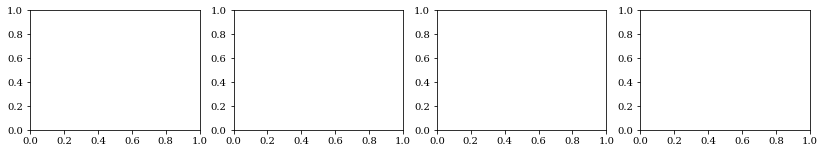

In [8]:
# plot
method_format = {#'random_arm': ('Random Arm', 'g', '.', '--'), 
                 #'random_data': ('Random', 'b', '^', '--'), 
                 #'random_arm_informed': ('Random Arm Informed', 'g', '.', '-'), 
                 'random_data_informed': ('Random Informative', 'b', '^', '-'), 
                 #'ts_uniform': ('TS Symmetric', 'k', '*', '-'), 
                 'ts_informed': ('TS Informative', 'r', '+', '-'),}


fig, axes = plt.subplots(nrows=1, ncols=len(DATASET_LIST), figsize=(LINEWIDTH,2.2),
                        gridspec_kw = {'wspace':0.2, 'hspace':0.25})
for i, dataset_name in enumerate(DATASET_LIST):
    start = 0
    num_steps = l2_error[dataset_name][method_name].shape[1] - 1
    stepsize = 1
    for method_name in method_format:
        legend_name, color, marker, linestyle = method_format[method_name]    
        xrange = np.arange(num_steps) * LOG_FREQ + LOG_FREQ
        idx = np.arange(num_steps)[start:(start+num_steps)][::stepsize]  
        
        y = l2_error[dataset_name][method_name]/ l2_error[dataset_name]['scores']
        eval_mean = np.mean(y, axis=0)
        eval_upper = np.quantile(y, 0.875, axis=0)
        eval_lower = np.quantile(y, 0.125, axis=0)
        axes[i].plot(xrange[idx], 
                 eval_mean[idx], 
                 label=legend_name, linewidth=3, color=color, linestyle=linestyle)
        axes[i].fill_between(xrange[idx], 
                         eval_lower[idx], 
                         eval_upper[idx], 
                         color=color, alpha=.2)
        #plt.ylim([0, 0.3])
    axes[i].set_xlabel('#Labeled')
    axes[i].set_xscale('log')
    #axes[i].set_yscale('log')
    axes[i].set_title(DATASET_NAMES[dataset_name])
axes[0].legend(fontsize=10, loc='upper right')
axes[0].set_ylabel('$L_2$ Error')

In [ ]:
l2_error[dataset_name]['diagonal'], l2_error[dataset_name]['ones']

In [ ]:
# plot
method_format = {#'random_arm': ('Random Arm', 'g', '.', '--'), 
                 #'random_data': ('Random', 'b', '^', '--'), 
                 #'random_arm_informed': ('Random Arm Informed', 'g', '.', '-'), 
                 'random_data_informed': ('Random Informed', 'b', '^', '-'), 
                 #'ts_uniform': ('TS Symmetric', 'k', '*', '-'), 
                 'ts_informed': ('TS Informed', 'r', '+', '-'),}


fig, axes = plt.subplots(nrows=2, ncols=len(DATASET_LIST)//2, figsize=(LINEWIDTH*0.5,4.3),
                        gridspec_kw = {'wspace':0.2, 'hspace':0.3})
for i, dataset_name in enumerate(DATASET_LIST):
    for method_name in method_format:
        start = 0
        num_steps = min(l2_error[dataset_name][method_name].shape[1],
                       np.argmax(l2_error[dataset_name]['ts_informed'] < (1e-7)))
        #num_steps = max(num_steps, int(l2_error[dataset_name][method_name].shape[0]*0.1))- start
        print(num_steps)
        stepsize = 1
    
        legend_name, color, marker, linestyle = method_format[method_name]    
        xrange = np.arange(num_steps) * LOG_FREQ + LOG_FREQ
        idx = np.arange(num_steps)[start:(start+num_steps)][::stepsize]  
        
        tmp = l2_error[dataset_name][method_name] / l2_error[dataset_name]['ts_informed']
        eval_mean = np.mean(tmp, axis=0) 
        eval_upper = np.quantile(tmp, 0.875, axis=0)
        eval_lower = np.quantile(tmp, 0.125, axis=0)
        axes[i//2, i%2].plot(xrange[idx], 
                 eval_mean[idx], 
                 label=legend_name, linewidth=3, color=color, linestyle=linestyle)
        axes[i//2, i%2].fill_between(xrange[idx], 
                         eval_lower[idx], 
                         eval_upper[idx], 
                         color=color, alpha=.2)
        #plt.ylim([0, 0.3])
    axes[1, i%2].set_xlabel('#Labeled')
    axes[i//2, i%2].set_xscale('log')
    axes[i//2, i%2].set_title(DATASET_NAMES[dataset_name])
    axes[i//2,0].set_ylabel('Ratio of $L_2$ Error')
axes[0,0].legend(fontsize=10, loc='lower right')

In [ ]:
l2_error[dataset_name][method_name].shape

In [ ]:
fig.savefig('../figures/confusion_l2_ratio_pseudocount%d.pdf' % (pseudocount*100), \
            dpi=300, bbox_inches='tight', pad_inches=0)   

In [ ]:
# plot
method_format = {#'random_arm': ('Random Arm', 'g', '.', '--'), 
                 'random_data': ('Random', 'b', '^', '--'), 
                 #'random_arm_informed': ('Random Arm Informed', 'g', '.', '-'), 
                 'random_data_informed': ('Random Informed', 'b', '^', '-'), 
                 #'ts_uniform': ('TS Symmetric', 'k', '*', '-'), 
                 'ts_informed': ('TS Informed', 'r', '+', '-'),}


fig, axes = plt.subplots(nrows=1, ncols=len(DATASET_LIST)+3, figsize=(LINEWIDTH,3),
                        gridspec_kw = {'wspace':0.2, 'hspace':0.25})
for i, dataset_name in enumerate(DATASET_LIST):
    start = 0
    num_steps = logp[dataset_name][method_name].shape[1] - 1
    stepsize = 1
    for method_name in method_format:
        legend_name, color, marker, linestyle = method_format[method_name]    
        xrange = np.arange(num_steps) * LOG_FREQ + LOG_FREQ
        idx = np.arange(num_steps)[start:(start+num_steps)][::stepsize]   
        axes[i].plot(xrange[idx], 
                 np.mean((logp[dataset_name][method_name]), axis=0)[idx], 
                 label=legend_name, linewidth=3, color=color, linestyle=linestyle)
        axes[i].fill_between(xrange[idx], 
                         np.quantile(logp[dataset_name][method_name], 0.125, axis=0)[idx], 
                         np.quantile(logp[dataset_name][method_name], 0.875, axis=0)[idx], 
                         color=color, alpha=.2)
        #plt.ylim([0, 0.3])
    axes[i].set_xlabel('#Labeled')
    axes[i].set_xscale('log')
    #axes[i].set_yscale('log')
    axes[i].set_title(DATASET_NAMES[dataset_name])
axes[0].legend(fontsize=10, loc='upper right')
axes[0].set_ylabel('$L_2$ Error')